# Introduction and TCGA background

Liver cancer has the second highest worldwide cancer mortality rate and has limited therapeutic options.

The most common form of liver cancer is hepatocellular carcinoma (HCC), making up 80% of liver cancer cases in the US. HCC is the 9th leading cause of cancer-related deaths in the US, and third worldwide.[1](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/liver)


A consortium known as The Cancer Genome Atlas (TCGA) network has made a plethora of molecular information on various cancers, including HCC publicly available. This data include genetic, molecular, diagnostic, demographic, and clinical information from over 350 patients with HCC. 

While surgery can be an effective method for treating early-stage liver cancer, there are few options for more advanced and metastatic tumors. Sorafenib and regorafinib are the only approved treatments for managing advanced HCC, and many others potential therapeutics have failed in Phase III clinical trials. [Previous studies](https://www.cell.com/cell/fulltext/S0092-8674(17)30639-6) studying genomic alterations in samples have found frequently-mutated genes LZTR1, EEF1A1, SF3B1, and SMARCA4.

In addition to DNA alterations however, different biological and tumor microenvrionment factors can influence disease progression. A transcriptomic survey of tissues at various stages of disease progression could help elucidate some of the underlying pathways contributing to tumorigenesis.

## RNA Seq

In this post, we'll be exploring a liver cancer RNA-seq dataset from TCGA. TCGA represents one of the most comprehensive publically-available datasets for cancer research. This tutorial will walk through several steps in how to obtain, process, explore and model gene expression data as it relates to cancer genomics.

In biology, copies of our DNA are used as a template for creating different biological products and proterins. This intermediate copy is known as RNA. Unlike DNA, which is relatively static, RNA can change dynamically depending on environmental factors and stimuli. Technological and commercial advances in next-generation sequencing provided cost-effective methods for conducting RNA-sequencing (RNA-seq) in experiments and a plethora of data. 

Traditionally, RNA is extracted from a sample, and transcribed to a more stable DNA copy(known as complementary DNA because it's the complement to the RNA sample). Sequencing works by attaching one side of each RNA molecule to a surface and repeatedly cycling through a process of attaching colored probes that bind to the RNA, imaging the probe, and washing off the probe. Rinse and repeat.

Following this process we now have tons of strings of T's,C's,G's, and A's that has been barcoded on either side of the sequence. Since each barcode attaches to a known and unique sequence of a gene, we can match these sequences to a reference genome.

Once the sequences have been mapped to their corresponding genes, we now have a quantification of gene expression for our samples. Depending on the question we are looking to answer, comparisons of gene expression between experimental conditions can be used to understand whether particular genetic components and molecular pathways influence that treatment. For instance by performing RNA-seq on normal and tumor liver tissue can show granular differences in actively expressed (or suppressed) genes and provide insight into the role of certain gentic components in influencing tumor progression.

## TODO

Intro to the data


Preparing our data


## Accessing the data

**We'll be focusing on using RNA-seq data from LIHC combined with clinical attributes to identify biomarkers for disease progression.**

TCGA provides raw RNA-seq reads and other clinical data [here](https://portal.gdc.cancer.gov/projects/TCGA-LIHC) and in the R package _[RTCGA](http://rtcga.github.io/RTCGA/)_. This data is already outputted in the accompanying [GitHub](https://github.com/nyhais/hacknights/tree/master/tcga-series/post) as well.

We will be investigating the [Hepatocellular carcinoma dataset(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5680778/). The TCGA RNASeq data is illumina hiseq Level 3 RSEM normalized expression data. You can read about thec RSEM method [here](https://academic.oup.com/bioinformatics/article/26/4/493/243395).

Essentially this is the raw counts of reads that aligned to the gene transcript, though it's only a guess by the program. Since it's a guess, the values are rational numbers. To simplify things, we'll round the values to the next whole integer. 

Before we start any kind of modeling, it's a good idea to observe some high levels patterns within our data to make sure that with all the steps in our process, our data looks accurate.

RNA-seq datasets provide a unique challenge in that they tend to be very wide (~20k genes for a human genome) and short (sequencing information on clinical samples can be expensive or unavailable and certain conditions may be very rare).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dir=""
response_name="patient.race"
rnaseq_file=data_dir+"../workshop3/lihc_rnaseq.csv.gz"
clinical_file=data_dir+"../workshop3/revised_clinical.tsv"

First let's load the data:

In [10]:
rnaseq = (pd.
          read_csv('X.csv.gzip',compression="gzip")
#           set_index('bcr_patient_barcode').
#           applymap(lambda x : int(np.ceil(x)))
         )
display(rnaseq.shape)
display(rnaseq.head())

(423, 20502)

,Unnamed: 0,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,tcga-2v-a95s-0,22283,584,0,375,0,286320,81,543,1,...,25,274,795,19,500,3173,891,511,4,7
1,tcga-2y-a9gs-1,22642,1573,3,99,0,31169,163,2,1,...,69,633,1154,72,1001,5302,756,861,7,483
2,tcga-2y-a9gt-2,77670,1281,0,215,1,19515,119,1,3,...,47,1220,1134,13,1290,3220,861,524,15,84
3,tcga-2y-a9gu-3,9323,1253,0,2914,2,243941,72,0,0,...,19,286,1151,10,942,3093,1340,344,3,3
4,tcga-2y-a9gv-4,84243,1641,0,404,0,8756,83,0,9,...,42,1000,1632,5,1381,2903,576,666,3,120


In [14]:
rnaseq.describe()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,...,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,50231.567376,1698.881797,0.990544,299.981087,0.869976,88954.721040,179.319149,12.416076,4.898345,897.635934,...,31.174941,634.659574,973.817967,45.593381,1006.560284,3783.862884,699.167849,576.059102,9.049645,94.184397
std,49856.735087,858.645373,11.855365,286.785948,2.651946,93914.773995,204.444038,66.469798,15.659940,265.338262,...,15.873243,461.145316,264.967274,51.522508,505.714787,2093.308562,310.587919,226.443655,26.050805,96.808205
min,27.000000,0.000000,0.000000,8.000000,0.000000,1726.000000,13.000000,0.000000,0.000000,397.000000,...,0.000000,20.000000,217.000000,0.000000,85.000000,300.000000,168.000000,164.000000,0.000000,0.000000
25%,16013.000000,1116.500000,0.000000,157.000000,0.000000,22638.500000,68.000000,0.000000,0.000000,714.500000,...,20.000000,332.500000,791.000000,9.000000,627.000000,2325.500000,477.500000,423.500000,2.000000,11.500000
50%,40262.000000,1588.000000,0.000000,239.000000,0.000000,65570.000000,114.000000,1.000000,0.000000,852.000000,...,30.000000,523.000000,942.000000,30.000000,896.000000,3512.000000,617.000000,543.000000,4.000000,77.000000
75%,75207.000000,2157.000000,0.000000,354.500000,0.000000,117118.500000,185.000000,3.000000,3.000000,1039.000000,...,40.500000,813.500000,1127.500000,62.000000,1269.500000,4760.500000,866.500000,698.000000,8.000000,139.000000
max,542016.000000,4612.000000,239.000000,2914.000000,23.000000,636516.000000,1859.000000,793.000000,245.000000,2487.000000,...,130.000000,4483.000000,2064.000000,406.000000,2813.000000,15605.000000,1823.000000,2094.000000,351.000000,694.000000


In [18]:
rnaseq.isna().sum()[rnaseq.isna().sum() > 0]

Series([], dtype: int64)

In [5]:
rnaseq = (pd.
          read_csv(rnaseq_file,compression="gzip").
          set_index('bcr_patient_barcode').
          applymap(lambda x : int(np.ceil(x)))
         )
display(rnaseq.shape)
display(rnaseq.head())

(423, 20531)

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,0,2,4,91,1018,0,142,1,0,0,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,0,27,3,72,640,0,123,2,0,0,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,0,0,5,96,743,0,96,2,1,0,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,0,6,6,62,1187,0,281,1,0,0,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,0,12,6,105,879,0,283,0,0,0,...,42,1000,1632,5,1381,2903,576,666,3,120


We can clean up the column titles by extracting the common gene symbols from each.

In [6]:
gene_name_logical = [len(x[0])>1 for x in rnaseq.columns.str.split('|')]
sub = rnaseq.loc[:,gene_name_logical]
sub.columns = [x[0] for x in sub.columns.str.split('|')]
rnaseq_sub = sub.copy()
rnaseq_sub.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-2V-A95S-01A-11R-A37K-07,22283,584,0,375,0,286320,81,543,1,1032,...,25,274,795,19,500,3173,891,511,4,7
TCGA-2Y-A9GS-01A-12R-A38B-07,22642,1573,3,99,0,31169,163,2,1,903,...,69,633,1154,72,1001,5302,756,861,7,483
TCGA-2Y-A9GT-01A-11R-A38B-07,77670,1281,0,215,1,19515,119,1,3,773,...,47,1220,1134,13,1290,3220,861,524,15,84
TCGA-2Y-A9GU-01A-11R-A38B-07,9323,1253,0,2914,2,243941,72,0,0,722,...,19,286,1151,10,942,3093,1340,344,3,3
TCGA-2Y-A9GV-01A-11R-A38B-07,84243,1641,0,404,0,8756,83,0,9,828,...,42,1000,1632,5,1381,2903,576,666,3,120


We'll also load the clinical data from TCGA. This contains over a thousand clinical features characterizing the place of care, demographics, and treatment of patients, as well as sample specifications and preparations.

In [34]:
clin = pd.read_csv(clinical_file, compression=None, delimiter='\t').set_index('case_id')
clin.to_csv('clinical_revised.csv')

In [7]:
clinical = pd.read_csv(clinical_file, compression=None, delimiter='\t').set_index('case_id')
display(clinical.shape)
display(clinical.head())

(377, 46)

,submitter_id,project_id,gender,year_of_birth,race,days_to_birth,ethnicity,vital_status,days_to_death,age_at_index,...,treatment_effect,initial_disease_status,treatment_type,therapeutic_agents,regimen_or_line_of_therapy,treatment_intent_type,treatment_anatomic_site,treatment_outcome,days_to_treatment_end,treatment_or_therapy
case_id,,,,,,,,,,,,,,,,,,,,,
bce25281-502e-4599-9679-32dc8462ffb1,TCGA-DD-A4NE,TCGA-LIHC,female,1936,white,-27549,hispanic or latino,Dead,660.0,75.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
654af137-70d9-4ee4-9f69-793e352d30f8,TCGA-DD-A1EE,TCGA-LIHC,male,1933,white,-26858,not hispanic or latino,Dead,349.0,73.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
45f00f00-d793-4dca-aeb9-7626d4575c90,TCGA-GJ-A9DB,TCGA-LIHC,male,1945,white,-25020,not hispanic or latino,Dead,67.0,68.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
496beef9-80d9-4734-a23d-334ae1b6aaab,TCGA-DD-AAC8,TCGA-LIHC,male,1936,asian,-26322,not hispanic or latino,Dead,16.0,72.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,no
d1aa9c1a-d732-48c0-b669-8a14e0397344,TCGA-2Y-A9GV,TCGA-LIHC,female,1953,white,-20011,not hispanic or latino,Dead,2532.0,54.0,...,--,--,"Pharmaceutical Therapy, NOS",--,--,--,--,--,--,yes


## Exploratory data analysis

We can start by taking a look at the range of expression and distribution of geneset. Since we have 20k of themwhether certain genes are more highhigher or lower than the average level of 


RNA seq typically follows a negative bionomial distribution. If we take a look at the standard deviation of the log mean values vs the log of mean counts for each gene/transcript across patient samples.

Dispersion is a parameter that estimates variability within negative binomial distribution. Analagous for variance for normal distribution. Because never sampling randomly, dispersion does not penalize differences from mean.

In [8]:
exprs_genes = rnaseq_sub[rnaseq_sub>0].dropna(axis=1)
mean_vec = exprs_genes.mean().apply(np.log)
sd_vec = exprs_genes.std().apply(np.log)

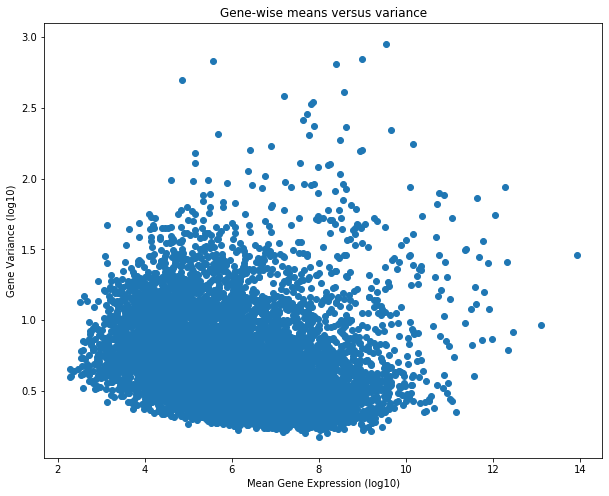

In [9]:
mean_vec = exprs_genes.apply(np.log).mean()
sd_vec = exprs_genes.apply(np.log).std()
fig = plt.figure(figsize=(10,8))
plt.scatter(mean_vec, sd_vec)
plt.title('Gene-wise means versus variance')
plt.xlabel('Mean Gene Expression (log10)')
plt.ylabel('Gene Variance (log10)');

It is obvious that the variance of counts is generally greater than their mean, especially for genes expressed at a higher level. This phenomenon is called “overdispersion“. The NB distribution is similar to a Poisson distribution but has an extra parameter called the “clumping” or “dispersion” parameter. It is like a Poisson distribution with more variance. Note, how the NB estimates of the mean-variance relationship (blue line) fits the observed values quite well. Thus, a reasonable first intuition of why the NB distribution is a proper way of fitting count data is that the dispersion parameter allows the extra wiggle room to model the “extra” variance that we empirically observe in RNA-Seq experiments.

Let's choose a couple genes known to be related to the hallmarks of cancer. In the Github repo, you'll find a list of genes associated with the major hallmarks of cancer.

In [10]:
import pickle

gene_dict = pickle.load(open('hallmarks_of_cancer_geneset_dictionary.pkl', 'rb'))
gene_dict

{'HALLMARK_ADIPOGENESIS': array(['ABCA1', 'ABCB8', 'ACAA2', 'ACADL', 'ACADM', 'ACADS', 'ACLY',
        'ACO2', 'ACOX1', 'ADCY6', 'ADIG', 'ADIPOQ', 'ADIPOR2', 'AGPAT3',
        'AIFM1', 'AK2', 'ALDH2', 'ALDOA', 'ANGPT1', 'ANGPTL4', 'APLP2',
        'APOE', 'ARAF', 'ARL4A', 'ATL2', 'ATP1B3', 'ATP5PO', 'BAZ2A',
        'BCKDHA', 'BCL2L13', 'BCL6', 'C3', 'CAT', 'CAVIN1', 'CAVIN2',
        'CCNG2', 'CD151', 'CD302', 'CD36', 'CDKN2C', 'CHCHD10', 'CHUK',
        'CIDEA', 'CMBL', 'CMPK1', 'COL15A1', 'COL4A1', 'COQ3', 'COQ5',
        'COQ9', 'COX6A1', 'COX7B', 'COX8A', 'CPT2', 'CRAT', 'CS', 'CYC1',
        'CYP4B1', 'DBT', 'DDT', 'DECR1', 'DGAT1', 'DHCR7', 'DHRS7',
        'DHRS7B', 'DLAT', 'DLD', 'DNAJB9', 'DNAJC15', 'DRAM2', 'ECH1',
        'ECHS1', 'ELMOD3', 'ELOVL6', 'ENPP2', 'EPHX2', 'ESRRA', 'ESYT1',
        'ETFB', 'FABP4', 'FAH', 'FZD4', 'G3BP2', 'GADD45A', 'GBE1',
        'GHITM', 'GPAM', 'GPAT4', 'GPD2', 'GPHN', 'GPX3', 'GPX4', 'GRPEL1',
        'HADH', 'HIBCH', 'HSPB8', 'IDH1', 'IDH3

Loading the dictionary, we see that apoptosis, or programmed cell death, is one of the Hallmarks of Cancer. Let's look at the range of expression for a subset of genes across patient samples related to apoptosis.

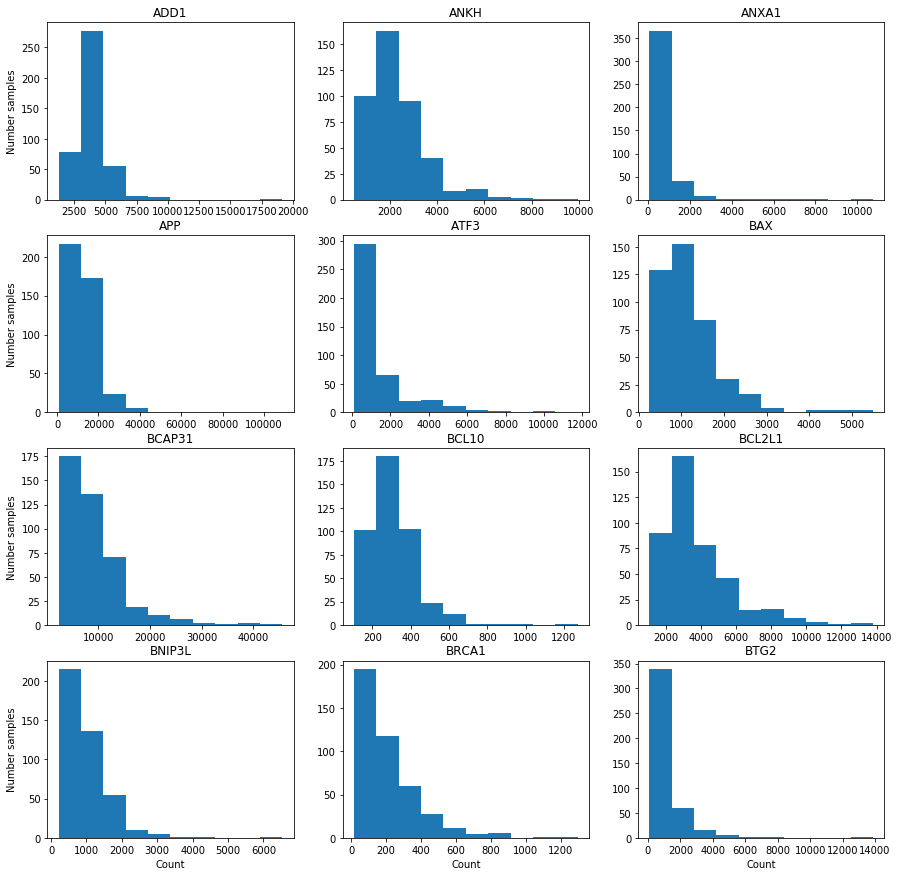

In [11]:
# Plot range of gene expression values
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
genes = ['ADD1', 'ANKH', 'ANXA1', 'APP', 'ATF3', 'BAX', 'BCAP31', 'BCL10', 'BCL2L1', 'BNIP3L', 'BRCA1', 'BTG2']
i = 0
for row in range(rows):
    for col in range(cols):
        axs[row, col].hist(exprs_genes[genes[i]].values)
        axs[row, col].title.set_text(genes[i])
        if col%3 == 0:
            axs[row, col].set_ylabel('Number samples')
        if row >= 3:
            axs[row, col].set_xlabel('Count')
        i += 1



Just by looking at a few of these genes, we can see that expression varies differently between tumor samples. Some genes tend to have a heavy left skew, while others tend to cluster above low expression. We can also see that the range of values varies greatly both within and between genes.

Let's look at a couple of genes related to homeostasis:

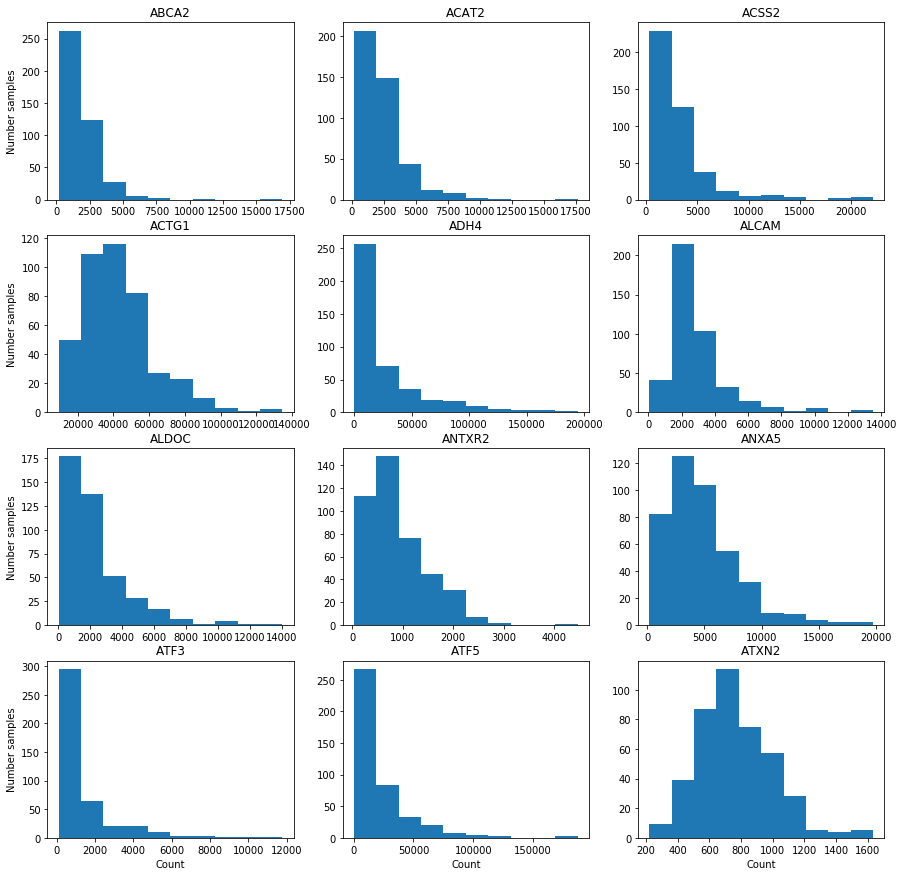

In [12]:
# Plot range of gene expression values
rows, cols = 4, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,15))
genes = ['ABCA2', 'ACAT2', 'ACSS2', 'ACTG1', 'ADH4', 'ALCAM', 'ALDOC',
        'ANTXR2', 'ANXA5', 'ATF3', 'ATF5', 'ATXN2', 'AVPR1A']
i = 0
for row in range(rows):
    for col in range(cols):
        axs[row, col].hist(exprs_genes[genes[i]].values)
        axs[row, col].title.set_text(genes[i])
        if col%3 == 0:
            axs[row, col].set_ylabel('Number samples')
        if row >= 3:
            axs[row, col].set_xlabel('Count')
        i += 1

Let's look at gene expression across the entire set of expressed genes.

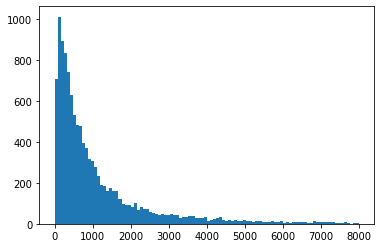

In [13]:
plt.hist(exprs_genes.mean(axis=0), range=(0, 8000), bins=100);

Plotting the entire range of expressed genes shows that while the majority of genes have counts <= 4000, there are some which have an average expression over 500k counts. We can use our hallmark dictionary to take a look at some what some these genes are involved in.

In [14]:
# Turn gene_dict into a dataframe
gene_df = pd.DataFrame.from_dict(gene_dict, orient = 'index').reset_index() \
    .melt(id_vars=["index"], 
            var_name="col", 
            value_name="gene") \
    .drop('col', axis=1) \
    .dropna()
gene_df.rename(columns={'index': 'hallmark'}, inplace=True)
gene_df

,hallmark,gene
0,HALLMARK_ADIPOGENESIS,ABCA1
1,HALLMARK_ALLOGRAFT_REJECTION,AARS
2,HALLMARK_ANDROGEN_RESPONSE,ABCC4
3,HALLMARK_ANGIOGENESIS,APOH
4,HALLMARK_APICAL_JUNCTION,ACTA1
...,...,...
9983,HALLMARK_MYOGENESIS,WWTR1
9985,HALLMARK_OXIDATIVE_PHOSPHORYLATION,VDAC3
9986,HALLMARK_P53_PATHWAY,ZNF365
9994,HALLMARK_TNFA_SIGNALING_VIA_NFKB,ZFP36


In [15]:
highly_exprs_genes = pd.DataFrame(exprs_genes.mean()[exprs_genes.mean(axis=0) > 100000])
highly_exprs_genes = pd.merge(highly_exprs_genes.reset_index(), gene_df, left_on='index', right_on='gene')
highly_exprs_genes

,index,0,hallmark,gene
0,ALB,1.942837e+06,HALLMARK_PEROXISOME,ALB
1,ALDOB,1.316031e+05,HALLMARK_HYPOXIA,ALDOB
2,ALDOB,1.316031e+05,HALLMARK_GLYCOLYSIS,ALDOB
3,APOA1,2.445005e+05,HALLMARK_COAGULATION,APOA1
4,APOA1,2.445005e+05,HALLMARK_BILE_ACID_METABOLISM,APOA1
5,APOC1,1.463239e+05,HALLMARK_COAGULATION,APOC1
6,APOC1,1.463239e+05,HALLMARK_COMPLEMENT,APOC1
7,APOC3,1.248927e+05,HALLMARK_COAGULATION,APOC3
8,APOE,2.116336e+05,HALLMARK_ADIPOGENESIS,APOE
9,APOE,2.116336e+05,HALLMARK_XENOBIOTIC_METABOLISM,APOE


Coagulation seems to be highly expressed in these samples.

In [16]:
highly_exprs_genes.hallmark.value_counts()

HALLMARK_COAGULATION                          11
HALLMARK_COMPLEMENT                            6
HALLMARK_XENOBIOTIC_METABOLISM                 4
HALLMARK_KRAS_SIGNALING_UP                     3
HALLMARK_ADIPOGENESIS                          3
HALLMARK_ANGIOGENESIS                          2
HALLMARK_ESTROGEN_RESPONSE_LATE                2
HALLMARK_CHOLESTEROL_HOMEOSTASIS               1
HALLMARK_MYOGENESIS                            1
HALLMARK_BILE_ACID_METABOLISM                  1
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY       1
HALLMARK_INTERFERON_GAMMA_RESPONSE             1
HALLMARK_HYPOXIA                               1
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION     1
HALLMARK_PEROXISOME                            1
HALLMARK_APOPTOSIS                             1
HALLMARK_GLYCOLYSIS                            1
HALLMARK_HEME_METABOLISM                       1
Name: hallmark, dtype: int64

## Clinical Data

One of the questions that we are interested in understanding is whether there are RNA signatures that are change according to disease progression for hepatocellular carcinoma. Taking a look at the clinical characteristics we find that tumor stage is one of the features available in the clinical data set.

A quick look at tumor stages shows that there are 4 main stages of HCC, with stage 1 being the least invasive and stage 4 being being advanced or metastatic cancer.

In [17]:
clinical['tumor_stage'].value_counts()

stage i         175
stage ii         87
stage iiia       65
not reported     24
stage iiic        9
stage iiib        9
stage iii         3
stage iv          2
stage ivb         2
stage iva         1
Name: tumor_stage, dtype: int64

We will join our clinical characteristics with the RNA-seq data.

In [18]:
# Since the barcodes vary slightly, we'll need to reformat the colummns to match each other first
rnaseq_sub.index= rnaseq_sub.reset_index()['bcr_patient_barcode'].apply(lambda barcode: '-'.join(barcode.split('-')[:3])).values
rnaseq_sub.index.name = 'bcr_patient_barcode'

In [19]:
# Merge the clinical and rna-seq data
full_df = pd.merge(rnaseq_sub.reset_index(), clinical[['submitter_id','tumor_stage']], left_on='bcr_patient_barcode', right_on='submitter_id', how='inner') \
    .set_index('bcr_patient_barcode') \
    .drop('submitter_id', axis=1)
#ensuring ID uniqueness
full_df.index = [x+'-'+str(i) for i,x in enumerate(full_df.index)]
full_df.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,tumor_stage
TCGA-2V-A95S-0,22283,584,0,375,0,286320,81,543,1,1032,...,274,795,19,500,3173,891,511,4,7,stage ii
TCGA-2Y-A9GS-1,22642,1573,3,99,0,31169,163,2,1,903,...,633,1154,72,1001,5302,756,861,7,483,not reported
TCGA-2Y-A9GT-2,77670,1281,0,215,1,19515,119,1,3,773,...,1220,1134,13,1290,3220,861,524,15,84,stage i
TCGA-2Y-A9GU-3,9323,1253,0,2914,2,243941,72,0,0,722,...,286,1151,10,942,3093,1340,344,3,3,stage i
TCGA-2Y-A9GV-4,84243,1641,0,404,0,8756,83,0,9,828,...,1000,1632,5,1381,2903,576,666,3,120,stage i


We'll also clean up our data, combining all the sub-stages into one of the four main tumor stages (stage i, stage ii, stage iii, stage iv) and removing any unreported instances for now.

In [20]:
# Subset full dataframe for patient samples that have a corresponding tumor stage
full_df = full_df.loc[full_df['tumor_stage'].str.startswith('stage')]

# Since there are substages (eg, stage iia and stage iib), we will convert them to the 4 main stages
full_df['tumor_stage'] = full_df['tumor_stage'].str.replace('stage ', '') \
                            .str.replace('a', '') \
                            .str.replace('b', '') \
                            .str.replace('c', '') \
                            .str.replace('v', '')
full_df['tumor_stage'].value_counts()

i      196
ii      98
iii     97
Name: tumor_stage, dtype: int64

In [25]:
full_df.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,tumor_stage
TCGA-2V-A95S-0,22283,584,0,375,0,286320,81,543,1,1032,...,274,795,19,500,3173,891,511,4,7,ii
TCGA-2Y-A9GT-2,77670,1281,0,215,1,19515,119,1,3,773,...,1220,1134,13,1290,3220,861,524,15,84,i
TCGA-2Y-A9GU-3,9323,1253,0,2914,2,243941,72,0,0,722,...,286,1151,10,942,3093,1340,344,3,3,i
TCGA-2Y-A9GV-4,84243,1641,0,404,0,8756,83,0,9,828,...,1000,1632,5,1381,2903,576,666,3,120,i
TCGA-2Y-A9GW-5,73056,1423,0,270,0,43813,299,0,1,622,...,1647,707,30,748,8467,993,457,7,103,i


In [30]:
full_df.index.name = 'bcr_patient_barcode'
full_df.reset_index().to_csv('full_df.csv', index=False)

Now that we have an attribute to differentiate samples, we can explore how patterns of expression may differ between these groups.

## Differential Expression Analysis

We can statistically test for a difference in gene expression by performing a hypothesis test for each gene to see whether there is evidence to decide that expression is signficantly different between conditions. 
In this section, we will investigate differential expression results derived from the [DESeq2] package in R. Also see this [vignette](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) on how to do these analyses, as well as understand the methods. 

Briefly, a Sample x Gene matrix of raw count reads and a matching matrix of phenotypes (eg, treatment or condition) for each sample are inputted into DEseq2. In order to account for RNA composition bias and library size, when only a small number of genes are highly expressed in one condition vs another, these genes are normalized by diving the expression by the mean expression for each gene across samples. 

DEseq2 fits a [negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) generalized linear model to each gene and uses the [Wald test](https://www.statisticshowto.datasciencecentral.com/wald-test) for significance. Outliers are detected using Cooke's distance and removed from the dataset. Genes with low normalized mean expression values below a threshbold are also removed to improve detection power. https://chipster.csc.fi/manual/deseq2.html

### Running differential expression analysis via DEseq2
We've created a subprocess to run the R package DEseq2 with our data and return the results in a python-friendly format. 

To run this script on the command line use:
```
Rscript TCGA_differential_expression_analysis.R full i ii
```

(script name | rna_seq_file.csv.gz | clinical_data_file.csv.gz | num_genes_to_run | clinical_attribute_col | atttribute 1 | attribute 2

Use the output of this file to plot and identify differentially-expressed genes. You can change the clinical columns, attributes and number of genes to explore additional clinical variables.

Viewing the results from running differential expression analysis, we can see the output consists of the genes sampled in each row, along with the mean expression of that gene, the fold change and the pvalue of whether it was significantly expressed

In [19]:
de_stage_i_ii = pd.read_csv('lihc_DESeq2_full_sampled_genes_tumor_stage_i_vs_ii.csv')
de_stage_i_ii.head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene
0,51530.278974,0.317265,0.195171,1.625571,0.104041,0.434561,A1BG
1,1701.155417,0.039452,0.115477,0.341640,0.732622,0.947396,A1CF
2,0.341469,0.110960,0.629613,0.176235,0.860110,0.978906,A2BP1
3,302.325877,0.159307,0.126984,1.254540,0.209646,0.602383,A2LD1
4,0.846050,-0.490344,0.569334,-0.861260,NaN,NaN,A2ML1
5,89226.274345,0.189610,0.181457,1.044929,0.296056,0.692876,A2M
6,175.277808,-0.308768,0.147156,-2.098233,0.035885,0.257278,A4GALT
7,8.285526,0.259137,0.421185,0.615256,NaN,NaN,A4GNT
8,4.749911,0.524862,0.416442,1.260348,0.207544,0.599819,AAA1
9,891.054745,-0.073471,0.049676,-1.479006,0.139139,0.498075,AAAS


Create a diagnostic plots to help us visualize the data. An MA-plot shows the log2 fold changes from the treatment over the mean of normalized counts, i.e. the average of counts normalized by size factor. 

Observing the log2 Fold change, we see most genes decrease in expression in stage II samples. A fold-change of +/- 2 is often considered a threshold for significant differential expression.

/Users/mattheweng/Desktop/Galvanize/Projects/hacknights/env-tcga/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mattheweng/Desktop/Galvanize/Projects/hacknights/env-tcga/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


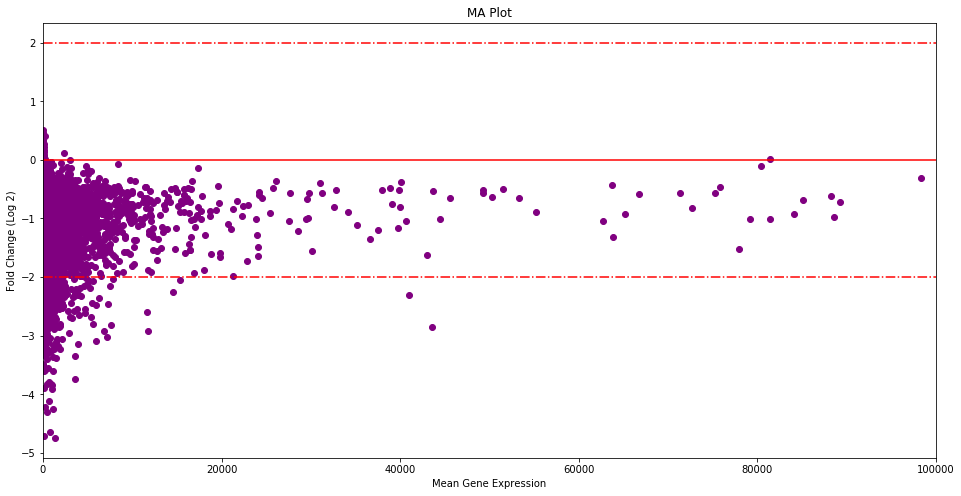

In [20]:
plt.figure(figsize=(16,8))
plt.scatter(de_stage_i_ii['baseMean'], np.log10(de_stage_i_ii['log2FoldChange']), c='purple')
plt.xlim(0,100000);
plt.xlabel('Mean Gene Expression')
plt.ylabel('Fold Change (Log 2)')
plt.title('MA Plot')
plt.plot(np.linspace(0, 100000, 100), np.linspace(0, 0, 100), c='red')
plt.plot(np.linspace(0, 100000, 100), np.linspace(2, 2, 100), c='red', ls='-.')
plt.plot(np.linspace(0, 100000, 100), np.linspace(-2, -2, 100), c='red', ls='-.')

We can subset the signficantly-expressed genes by p-value and fold-change

In [76]:
deg_i_ii = de_stage_i_ii[de_stage_i_ii['pvalue'] <= 0.01]
deg_i_ii = deg_i_ii[abs(deg_i_ii['log2FoldChange']) >= 2].sort_values('log2FoldChange')
deg_i_ii

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene
4335,5.137867,-4.002609,0.857635,-4.667030,3.055844e-06,5.167622e-04,CT45A1
7698,59.444529,-3.665525,0.479048,-7.651689,1.983570e-14,7.183911e-11,HEATR7B2
18351,17.022182,-3.301853,0.704600,-4.686135,2.784130e-06,4.836540e-04,TMPRSS15
16365,3.234402,-3.283411,0.671138,-4.892302,9.966361e-07,2.240555e-04,SLC6A15
18909,1.870359,-3.113032,0.446757,-6.968063,3.213333e-12,5.116965e-09,TUBAL3
15777,1.732108,-3.019926,0.742909,-4.065003,4.803190e-05,3.973340e-03,SERPINB4
7985,19.026081,-2.967751,0.563987,-5.262090,1.424272e-07,4.320067e-05,HOXB13
4125,3.655367,-2.933798,0.609392,-4.814305,1.477127e-06,2.880247e-04,CPA2
4031,17.228710,-2.892492,0.297759,-9.714202,2.622964e-22,5.012223e-18,COL4A6
13887,65.717795,-2.812945,0.422609,-6.656148,2.810977e-11,2.984164e-08,PPP1R1B


In [78]:
for i in deg_i_ii.Gene[:5]:
    print(i)

CT45A1
HEATR7B2
TMPRSS15
SLC6A15
TUBAL3


The gene ALDH3B2 appears to be significantly expressed

CT45A1 - shown to be contribute to tumorigenesis [when overexpressed](https://www.nature.com/articles/cddis2014244)
HEATR7B2
TMPRSS15 - enzyme that converts trypsinogen to trypsin
SLC6A15 - amino acid transporter, possibly involved in increased metabolism in [lung cancer](https://cancerres.aacrjournals.org/content/75/15_Supplement/1711)
TUBAL3 - tubulin 

In [75]:
for i in deg_i_ii.Gene.values:
    print(i)

CT45A1
HEATR7B2
TMPRSS15
SLC6A15
TUBAL3
SERPINB4
HOXB13
CPA2
COL4A6
PPP1R1B
SPINK4
UCHL1
SERPINB7
LOC285629
PIP
NR0B1
FIBCD1
SEPT14
VCY
IL13RA2
CDH18
HTR2C
ALX1
PLAC4
SPINK13
MMP10
GPR1
NKX2.5
C20orf70
TFF1
MS4A8B
SEMA3E
PHEX
DAPL1
SERPINB5
CTSE
ALDH3B2
NPTX1
SIX2
KCNK2
LOC100124692
DRGX
KIAA1324
DUOXA2
PNMT
UBE2DNL
DPCR1
MT1B
ECEL1
ANKRD26P1
MS4A10


In [65]:
# Find relevant GO terms
go_i_ii = bm[bm['HGNC symbol'].isin(deg_i_ii['Gene'])]
go_freq = go_i_ii.assign(frequency=go_i_ii.groupby('GO term accession')['GO term accession'] \
                             .transform('count')) \
                             .sort_values(['frequency', 'GO term accession'], ascending=False)
go_freq[80:120]

,GO term accession,GO term name,GO term definition,HGNC symbol,frequency
105106,GO:0005737,cytoplasm,All of the contents of a cell excluding the pl...,UCHL1,9.0
131139,GO:0005737,cytoplasm,All of the contents of a cell excluding the pl...,MT1B,9.0
183483,GO:0005737,cytoplasm,All of the contents of a cell excluding the pl...,PNMT,9.0
201166,GO:0005737,cytoplasm,All of the contents of a cell excluding the pl...,PPP1R1B,9.0
247875,GO:0005737,cytoplasm,All of the contents of a cell excluding the pl...,TUBAL3,9.0
43240,GO:0005634,nucleus,A membrane-bounded organelle of eukaryotic cel...,SIX2,9.0
54178,GO:0005634,nucleus,A membrane-bounded organelle of eukaryotic cel...,PIP,9.0
63900,GO:0005634,nucleus,A membrane-bounded organelle of eukaryotic cel...,NR0B1,9.0
131138,GO:0005634,nucleus,A membrane-bounded organelle of eukaryotic cel...,MT1B,9.0
201191,GO:0005634,nucleus,A membrane-bounded organelle of eukaryotic cel...,PPP1R1B,9.0


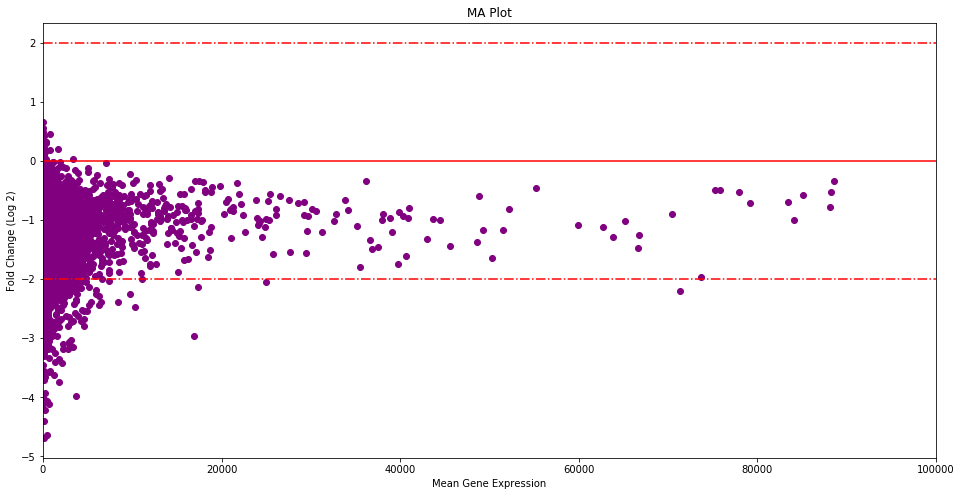

In [25]:
de_stage_ii_iii = pd.read_csv('lihc_DESeq2_full_sampled_genes_tumor_stage_ii_vs_iii.csv')

plt.figure(figsize=(16,8))
plt.scatter(de_stage_ii_iii['baseMean'], np.log10(de_stage_ii_iii['log2FoldChange']), c='purple')
plt.xlim(0,100000);
plt.xlabel('Mean Gene Expression')
plt.ylabel('Fold Change (Log 2)')
plt.title('MA Plot')
plt.plot(np.linspace(0, 100000, 100), np.linspace(0, 0, 100), c='red')
plt.plot(np.linspace(0, 100000, 100), np.linspace(2, 2, 100), c='red', ls='-.')
plt.plot(np.linspace(0, 100000, 100), np.linspace(-2, -2, 100), c='red', ls='-.')

### Pathway analysis
We can do a brief survey of what kinds of pathways and functions some of our differentially expressed genes are involved in. Using the [BioMart](http://www.biomart.org/martservice_9.html) service to annotate our genes with gene ontology (GO) terms.

There is one important point to keep in mind during the analysis: statistically significant is different from biologically meaningful. That said, it is typically possible to obtain some biological or technical insight about the underlying experiment from statistically enriched terms, even if it isn’t readily apparent.[Galaxy project](https://galaxyproject.github.io/training-material/topics/transcriptomics/tutorials/goenrichment/tutorial.html)

Terms that are very generic tend to be difficult to interpret, because the meaning they convey is shallow. On the other hand, very specific terms are generally not integrative and thus not useful in interpreting a gene set collectively. The interesting terms are those that are sufficiently specific to transmit substantial biological meaning, yet generic enough to integrate multiple genes.

In [33]:
from pybiomart import Dataset

In [34]:
dataset = Dataset(name='hsapiens_gene_ensembl',
                  host='http://www.ensembl.org')

attributes = [
    'go_id',
    'name_1006',
    'definition_1006',
    'hgnc_symbol',
]

bm = dataset.query(attributes=attributes,
#               filters={'chromosome_name': ['1','2']}
                  )

bm

,GO term accession,GO term name,GO term definition,HGNC symbol
0,NaN,NaN,NaN,MT-TF
1,NaN,NaN,NaN,MT-RNR1
2,NaN,NaN,NaN,MT-TV
3,NaN,NaN,NaN,MT-RNR2
4,NaN,NaN,NaN,MT-TL1
...,...,...,...,...
379049,GO:0019369,arachidonic acid metabolic process,The chemical reactions and pathways involving ...,NaN
379050,NaN,NaN,NaN,KIR2DL5B
379051,NaN,NaN,NaN,KIR2DS5
379052,NaN,NaN,NaN,KIR2DS3


In [35]:
bm.to_csv('go_terms.csv')

In [41]:
bm[bm['HGNC symbol'] == 'ALDH3B2']

,GO term accession,GO term name,GO term definition,HGNC symbol
17137,GO:0016491,oxidoreductase activity,Catalysis of an oxidation-reduction (redox) re...,ALDH3B2
17138,GO:0055114,oxidation-reduction process,A metabolic process that results in the remova...,ALDH3B2
17139,GO:0016620,"oxidoreductase activity, acting on the aldehyd...",Catalysis of an oxidation-reduction (redox) re...,ALDH3B2
17140,GO:0006629,lipid metabolic process,The chemical reactions and pathways involving ...,ALDH3B2
17141,GO:0005811,lipid droplet,An intracellular non-membrane-bounded organell...,ALDH3B2
17142,GO:0030148,sphingolipid biosynthetic process,The chemical reactions and pathways resulting ...,ALDH3B2
17143,GO:0004029,aldehyde dehydrogenase (NAD) activity,Catalysis of the reaction: an aldehyde + NAD+ ...,ALDH3B2
17144,GO:0043878,glyceraldehyde-3-phosphate dehydrogenase (NAD+...,Catalysis of the reaction: D-glyceraldehyde 3-...,ALDH3B2
17145,GO:0006066,alcohol metabolic process,The chemical reactions and pathways involving ...,ALDH3B2
17146,GO:0006068,ethanol catabolic process,The chemical reactions and pathways resulting ...,ALDH3B2


We see that ALDH3B2 is involved in metabolism of alcohols. Initial evidence suggests that decreased ALDH3B2 levels can be an [indicator of poor prognosis](https://aasldpubs.onlinelibrary.wiley.com/doi/full/10.1002/hep.29006) for HCC and that increased expression in cells and mice can inhibit tumor metastatic behavior.